# Initial Value Problems

Many phenomena in science, engineering, and economics are described not by their value, but by their *rate of change*. This leads us to differential equations. A very common form is the *initial value problem* (IVP), which we can write as:

$$
\begin{align*}
y'(t) &= f(t,y(t)), \quad t\ge t_0 \\
y(t_0) &= y_0
\end{align*}
$$

Here, $f(t,y)$ is a *right-hand side function* that defines the dynamics (the change), and $y(t_0) = y_0$ is the *initial condition* that specifies the state of the system at a starting time $t_0$. The independent variable $t$ often represents time.

In your calculus classes, you learned to find exact (or *closed-form*) solutions for some specific types of equations, like certain *linear* and *separable* equations. However, for many (if not most) real-world problems, finding an exact formula for $y(t)$ is impossible. 

This is where numerical methods come in! We'll learn how to use a computer to find a highly accurate *approximation* to the solution $y(t)$ at a series of discrete time points.

In [1]:
using Plots, LinearAlgebra

## Euler's Method: The Simplest Approach

The most basic and intuitive numerical method for IVPs is *Euler's method*. It's a great starting point for understanding all other methods.

![Euler_method](euler_method.png "Euler's method")
(from Wikipedia, <https://en.wikipedia.org/wiki/Euler_method>).

The core idea is simple: we start at our known point $(t_0, y_0)$ and take a small step forward in time, **assuming the slope (the derivative) is constant during that step**.

First, we choose a *step size*, $h$. This defines a set of discrete time points $t_n = t_0 + nh$ for $n = 0,1,2,\ldots$. We want to find the approximate solution $y_n$ at each time $t_n$.

At time $t_n$, we know the approximate value $y_n$ and we can calculate the slope $y'(t_n) = f(t_n, y_n)$. To find the next value $y_{n+1}$, we just follow this tangent line from $y_n$ for a duration of $h$:

$$
y_{n+1} = y_n + hf(t_n,y_n)
$$

This formula is just the definition of the derivative, $y'(t_n) \approx \frac{y_{n+1} - y_n}{h}$, rearranged to solve for $y_{n+1}$.

With some assumptions on the IVP and a small enough step size $h$, these values $y_n$ can be shown to be a good approximation to the true solution, $y_n \approx y(t_n)$.

While we've described this for a single (scalar) function $y(t)$, the method works exactly the same way for systems of equations, where $y(t)$ and $f(t,y(t))$ are vectors. This is why our implementation will be general.

## Implementing Euler's Method

Let's write a general Julia function for Euler's method. It will take the right-hand side function `f` as an argument, along with the initial condition `y0`, the step size `h`, and the total number of steps `N`. We'll also add an optional argument `t0` which defaults to 0.0.

Note that our implementation is designed to support vector-valued solutions from the start. We'll make `y0` a vector (or treat a scalar as a 1-element vector), and our output `y` will be a 2D array where each **column** represents the state $y_n$ at a given time step. This is a common and efficient convention in Julia.

In [2]:
function euler(f, y0, h, N, t0=0.0)
    # 1. Create the array of time points
    # t_n = t0 + n*h for n = 0, 1, ..., N
    t = t0 .+ h*(0:N)
    
    # 2. Initialize the solution array
    # We need N+1 columns to store y0, y1, ..., yN
    # length(y0) gives the size of the state vector (1 for scalar problems)
    y = zeros(length(y0), N+1)
    
    # 3. Set the initial condition
    # y[:,1] is the first column
    y[:,1] .= y0
    
    # 4. Loop N times to take N steps
    for n = 1:N
        # Apply the Euler update rule:
        # y_new = y_old + h * f(t_old, y_old)
        # We use y[:,n] to get the n-th column (the state at time t[n])
        # and store the result in the (n+1)-th column (the state at time t[n+1])
        y[:,n+1] = y[:,n] + h * f(t[n], y[:,n])
    end
    
    # 5. Return the time points and the solution history
    return t,y
end

euler (generic function with 2 methods)

### Example 1: A Simple Test Case

We'll demonstrate the method on a model problem: $f(t,y) = -y + \sin t$ with $y(0) = 1$. Let's first solve it using $h=0.2$ for $N=20$ steps, which will take us to a final time of $T = N \times h = 4.0$.

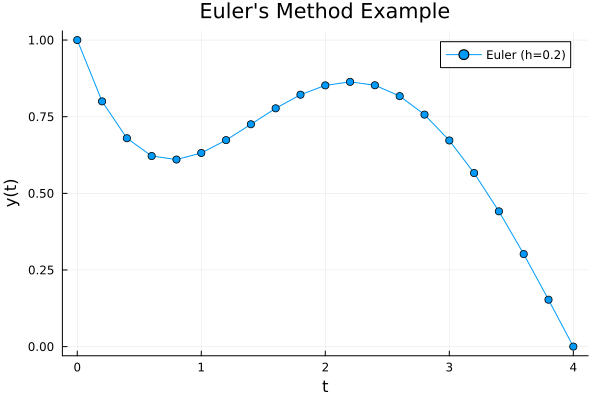

In [3]:
# Define the right-hand side function f(t,y)
# We use broadcasting (.-y .+ sin(t)) so it works for vector 'y'
f(t,y) = -y .+ sin(t)

# Run Euler's method:
# y0 = 1 (our scalar initial condition)
# h = 0.2
# N = 20 steps
t,y = euler(f, 1, 0.2, 20)

# Plot the result
# y is a 1x(N+1) array, so we plot the first row y[1,:]
plot(t, y[1,:], markershape=:circle, label="Euler (h=0.2)",
     title="Euler's Method Example", xlabel="t", ylabel="y(t)")

### Convergence of Euler's Method

A single run is nice, but the real test of a method is its *convergence*: does the approximate solution get closer to the true solution as we make the step size $h$ smaller?

Let's compare our numerical results to the exact analytical solution for this problem, which is:

$$
y_\mathrm{exact} = e^{-t} + (\sin t - \cos t + e^{-t}) / 2
$$

We'll write a helper function `run_testproblem` to solve the IVP from $t=0$ to $t=2.0$ using several different step sizes $h$ and plot them all against the exact solution. We'll also print the *maximum error* for each $h$.

Pay close attention to the error. We expect that as $h$ is cut in half (e.g., from 0.2 to 0.1), the error also gets cut in half. This is what we mean when we say the method is **first-order accurate** (the error scales *linearly* with $h$, or $O(h^1)$).

In [4]:
function run_testproblem(IVP_method)
    # 1. Define the exact solution as a Julia function
    yexact(t) = exp(-t) + (sin(t) - cos(t) + exp(-t)) / 2
    
    # 2. Create a fine time grid for plotting the exact solution
    tt = 0:0.01:2
    
    # 3. Plot the exact solution for reference
    plot(tt, yexact.(tt), label="Exact", lw=2,
         title="Method Convergence Test", xlabel="t", ylabel="y(t)")
    
    # 4. Loop over a few different step sizes
    for h = [0.5, 0.2, 0.1]
        # Calculate number of steps N to reach t=2.0
        N = round(Int, 2/h)
        
        # Run the provided solver (e.g., euler or rk4)
        t,y = IVP_method(f, 1, h, N)
        
        # Plot the numerical solution
        # Note: y[1,:] is used because our solvers return a 2D array
        plot!(t, y[1,:], markershape=:circle, label="h=$h")
        
        # 5. Calculate and print the maximum error
        # We compare the numerical solution y[1,:]
        # with the exact solution evaluated at the same time points, yexact.(t)
        max_err = maximum(abs.(y[1,:] - yexact.(t)))
        println("Method: $(string(IVP_method)), h=$h. Max error: $max_err")
    end
    
    # Display the final plot
    plot!()
end

run_testproblem (generic function with 1 method)

Method: euler, h=0.5. Max error: 0.21269073192494037
Method: euler, h=0.2. Max error: 0.07405303316185208
Method: euler, h=0.1. Max error: 0.034963406690659005


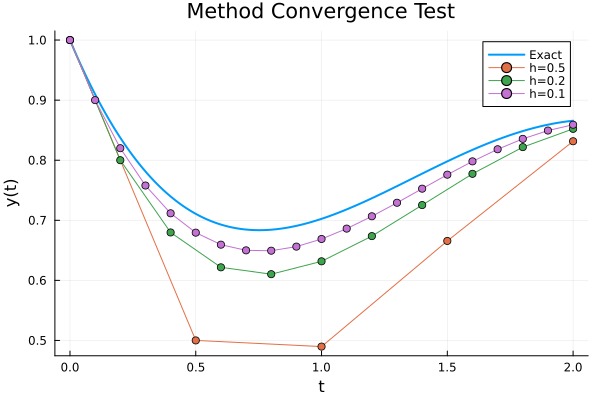

In [5]:
# Now, let's run the test harness with our 'euler' function.
# Observe the plot and the printed error values.
run_testproblem(euler)

## A Better Method: 4th-Order Runge-Kutta (RK4)

While Euler's method is simple to understand, its first-order convergence is often too slow for practical use. To get high accuracy, you'd need an extremely small $h$, which means many steps and a long computation time.

We can do much better. The idea is to **evaluate the slope $f(t,y)$ at several points *within* the step** (not just at the beginning) and combine them in a clever way to get a more accurate estimate. This is the central idea of the *Runge-Kutta* family of methods.

One of the most popular and widely used methods is the **4th-order Runge-Kutta method (RK4)**. It's a workhorse of numerical computation. For each step, it calculates four intermediate slopes (called *stages*), $k_1, k_2, k_3, k_4$:

$$
\begin{align*}
k_1 &= h f(t_n, y_n) \\
k_2 &= h f(t_n + h/2, y_n + k_1/2) \\
k_3 &= h f(t_n + h/2, y_n + k_2/2) \\
k_4 &= h f(t_n + h, y_n + k_3) \\
y_{n+1} &= y_n + (k_1 + 2k_2 + 2k_3 + k_4) / 6
\end{align*}
$$

Here's the intuition:
* $k_1$ is the familiar slope at the **beginning** of the step (just like Euler's method).
* $k_2$ is an estimate of the slope at the **midpoint** of the step, using $k_1$ to estimate the $y$-value at the midpoint.
* $k_3$ is *another* estimate of the slope at the **midpoint**, but using the more accurate $k_2$ to estimate the $y$-value.
* $k_4$ is an estimate of the slope at the **end** of the step, using $k_3$ to estimate the $y$-value.

The final update is a **weighted average** of these four slopes. Notice the slopes from the midpoint ($k_2, k_3$) are given more weight. This specific combination is what gives the method its **4th-order accuracy**. This means if we halve the step size $h$, the error should decrease by a factor of $2^4 = 16$! This is a *massive* improvement over Euler's method.

In [6]:
function rk4(f, y0, h, N, t0=0)
    # 1. Setup time and solution arrays, just like in euler()
    t = t0 .+ h*(0:N)
    y = zeros(length(y0), N+1)
    
    # 2. Set initial condition
    y[:,1] .= y0
    
    # 3. Loop N times to take N steps
    for n = 1:N
        # Calculate the four stages (k1, k2, k3, k4)
        # k1: slope at the beginning
        k1 = h * f(t[n], y[:,n])
        
        # k2: first midpoint slope estimate
        k2 = h * f(t[n] + h/2, y[:,n] + k1/2)
        
        # k3: second midpoint slope estimate
        k3 = h * f(t[n] + h/2, y[:,n] + k2/2)
        
        # k4: slope at the end
        k4 = h * f(t[n] + h, y[:,n] + k3)
        
        # 4. Combine the stages for the final update (weighted average)
        y[:,n+1] = y[:,n] + (k1 + 2*k2 + 2*k3 + k4) / 6
    end
    
    return t,y
end

rk4 (generic function with 2 methods)

Now for the exciting part. Let's run our `run_testproblem` harness again, but this time, we'll pass it our new `rk4` function. Compare the results directly to the Euler run.

Method: rk4, h=0.5. Max error: 0.00045648169894996204
Method: rk4, h=0.2. Max error: 8.887217012087945e-6
Method: rk4, h=0.1. Max error: 5.015261516083669e-7


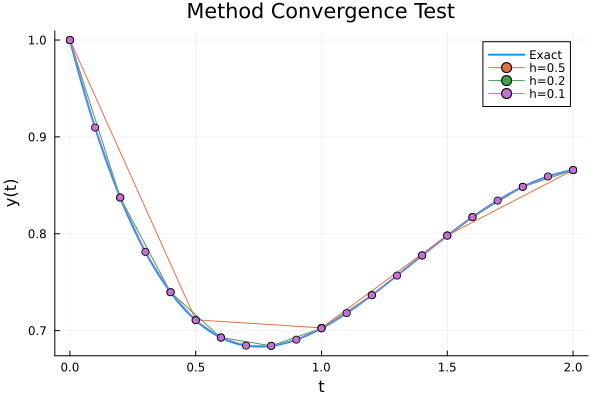

In [7]:
# Run the test harness with the 'rk4' function.
# Look at the plot and the printed error values.
run_testproblem(rk4)

### RK4 Analysis

The difference is remarkable!

* **On the plot:** All three RK4 solutions (even the one with a large step $h=0.5$) are visually indistinguishable from the exact solution.

* **The errors:** For $h=0.5$, the error is already on the order of $10^{-4}$, which is *significantly better* than Euler's method with $h=0.1$ (which had an error of $\sim 10^{-2}$).

* **Convergence Order:** Let's check the 4th-order claim. 
    * The error for $h=0.2$ is $\sim 9 \times 10^{-6}$.
    * The error for $h=0.1$ (halving the step) is $\sim 5 \times 10^{-7}$.
    * The *ratio* of the errors is $(9 \times 10^{-6}) / (5 \times 10^{-7}) \approx 18$. 
    This is close to the $16$ we predicted ($2^4 = 16$)! This confirms the 4th-order accuracy of the RK4 method.

This is the power of higher-order methods: they provide exceptional accuracy with a much larger step size, making them far more efficient for most problems.